In [ ]:
import numpy as np
import pandas as pd
import scipy.optimize as opt
from sklearn.covariance import EmpiricalCovariance
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure

## Data Exploration and Analysis

####  Pre-processing

We calculate the excess returns and subsequently treat RF as 0

In [ ]:
df = pd.read_csv('gp_data_1986_to_2015.csv')
Rf = df['RF'].values.copy()
for column in df.columns:
    if column in ['Month','RF', 'Mkt-RF']:
        continue
    df[column] -= Rf
df

,Month,Mkt-RF,RF,Agric,Food,Soda,Beer,Smoke,Toys,Fun,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
0,198601,0.65,0.56,7.36,1.82,-1.76,-1.42,4.99,1.58,3.35,...,1.35,5.04,1.92,1.11,-0.65,2.26,6.07,1.52,1.91,3.35
1,198602,7.13,0.53,13.45,7.36,11.15,7.18,11.67,10.19,7.75,...,10.08,6.50,8.32,6.68,8.74,10.51,6.88,6.46,7.65,10.75
2,198603,4.88,0.60,2.14,7.24,10.29,8.57,10.92,5.05,6.26,...,5.01,2.62,6.81,8.51,5.82,6.62,4.71,8.72,4.89,5.92
3,198604,-1.31,0.52,4.72,-1.09,3.92,-3.44,3.12,3.39,7.84,...,-1.45,-3.16,1.18,-1.22,3.34,-1.10,-6.62,-3.74,-3.81,-5.21
4,198605,4.62,0.49,0.59,8.06,7.46,5.88,9.67,2.67,5.42,...,4.58,0.21,5.03,11.46,4.40,3.71,5.23,-1.70,4.70,5.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,201508,-6.04,0.00,-4.59,-4.22,-4.57,-3.12,-4.06,-4.83,-7.79,...,-3.58,-6.36,-4.27,-5.42,-6.48,-6.35,-5.58,-11.06,-8.84,-5.49
356,201509,-3.07,0.00,-11.16,-1.73,2.15,2.58,2.37,-5.42,-10.75,...,-4.97,-0.72,-6.00,-1.72,0.44,-3.24,-1.99,-3.02,-5.03,-2.04
357,201510,7.75,0.00,8.63,5.44,5.77,8.06,10.90,11.86,15.14,...,9.78,6.47,5.17,4.53,5.05,5.60,5.23,10.65,7.63,7.10
358,201511,0.56,0.00,1.87,-1.59,2.36,-0.71,-3.00,-2.23,-0.08,...,-0.32,-1.11,2.70,0.59,-1.01,3.05,-0.25,-1.27,2.88,0.00


### Basic Portfolio Construction and In-sample analysis

In [ ]:
def estimate_V (data):
    
    ###########
    # (Basic) Estimate of the covariance matrix from histrocial return data
    # Input: Histrocial return data
    # Output: The basic estimate of covariance matrix of asset returns
    ###########
    
    Vhat = EmpiricalCovariance().fit(data).covariance_
    
    return Vhat

def estimate_mu (data):
    
    ###########
    # (Basic) Estimate of the expected return vector from histrocial return data
    # Input: Histrocial return data
    # Output: The basic estimate of expected return vector of all assets
    ###########
    
    mu_hat = EmpiricalCovariance().fit(data).location_
    
    return mu_hat

def tangency(mu, V):
    
    ###########
    # Construct the tangency portfolio using the closed form method
    # Input: mu is Estimated expected vector and V is the estimated covariance matrix
    # Output: The weights of the tangency portfolio
    ###########

    
    #tangency portfolio
    w_t = np.linalg.inv(V) @ mu
    w_t /= np.sum(w_t)

    return w_t
def gmv(V):
    
    ###########
    # Construct the global minimum variance portfolio using the closed form method
    # Input: V is the estimated covariance matrix
    #        NB: the expected return vector is not needed here!
    # Output: The weights of the global minimum variance portfolio
    ###########

    #GMV
    n = len(V)
    w_g = np.linalg.inv(V) @ np.ones(n)
    w_g /= np.sum(w_g)
    
    return w_g
def ewp(n):
    
    ###########
    # Construct the equally weighted portfolio
    # Input: n is the number of assets
    #        NB: neither the expected return vector nor covariance matrix is not needed here!
    # Output: The weights of the equally weighted portfolio
    ###########

    #GMV
    
    return np.ones(n)/n
    
def evaluate_portfolio_performance_on_data(w, data_evaluate):
    
    ###########
    # Evaluate the performance of a portfolio (i.e., weight vector) given the return data to evaluate on
    # Input: data contains historical return information (every column corresponds to an asset)
    #        w is the portfolio weight vector
    #        (NB: risk-free rate has already been assumed to be zero)
    # Output: The performance metrics of the portfolio 
    #         (i.e., expected return, standard deviation, variance, and Sharpe ratio)
    ###########
    
    # Sanity check for the input format
    w = w.reshape((-1))
    if (data_evaluate.shape[1] != len(w)):
        print('Warning: data and w should contain the same number of assets')
    ### End of sanity check
    
    V = estimate_V (data_evaluate)
    mu = estimate_mu (data_evaluate)
    
    
    return {'Er': mu.T @ w, 'sigma': np.sqrt(w.T @ V @ w), 
            'var': w.T @ V @ w, 'Sharpe': (mu.T @ w - 0)/(np.sqrt(w.T @ V @ w)) }


def get_EF_on_data (w_t, w_g, data_evaluate):

    ###########
    # Get the (evaluated) efficient frontier curve using the two-fund separation method
    #
    # Input: data contains historical return information to evaluate on (every column corresponds to an asset)
    #        w_t and w_g are the constructed tangency and global minimum variance portfolios, respectively
    #        (NB: if w_t and w_g are obtained from the training data but "data" is actually testing data,
    #         then the output EF could be highly sub-optimal!)
    # Output: The risk-return combinations of portfolios on the (evaluated) EF 
    ###########
    
    trange = np.arange(0,1.1,0.01)
    sigma_range = np.zeros_like (trange) * np.nan
    Er_range = np.zeros_like (trange) * np.nan

    for i in np.arange(len(trange)):
        w_mix = trange[i] * w_t + (1-trange[i]) * w_g
        sigma_range[i] = evaluate_portfolio_performance_on_data (w_mix, data_evaluate) ['sigma']
        Er_range[i] = evaluate_portfolio_performance_on_data (w_mix, data_evaluate) ['Er']
        
    return sigma_range, Er_range

In [ ]:
#Get the metrics for the market portfolio
mkt_portfolio = df['Mkt-RF']
mean_mkt_portfolio = mkt_portfolio.mean()
std_mkt_portfolio = mkt_portfolio.std()
sharpe_ratio_mkt_portfolio = mean_mkt_portfolio/std_mkt_portfolio
beta = 1 #since market portfolio 
market_portfolio = pd.DataFrame() 
market_portfolio.loc[0,'Mean'] = mean_mkt_portfolio
market_portfolio.loc[0,'SD'] = std_mkt_portfolio
market_portfolio.loc[0,'Sharpe Ratio'] =sharpe_ratio_mkt_portfolio
market_portfolio.loc[0,'Beta'] = 1
market_portfolio

,Mean,SD,Sharpe Ratio,Beta
0,0.636361,4.484527,0.141902,1.0


In [ ]:
#Calculate metrics for 48 industries
stocks = list(df.columns)[3:]
industry_assets = df.loc[:, stocks]
industry_portfolio = pd.DataFrame() 
mean_industry_assets = industry_assets.mean(axis = 0)
industry_portfolio['Mean'] = mean_industry_assets
industry_portfolio['SD'] = industry_assets.std(axis = 0)
industry_portfolio['Sharpe Ratio'] = industry_portfolio['Mean']/industry_portfolio['SD']
count = 0 
for i in range(len(stocks)):
    asset = df[stocks[i]]
    covariance_df = pd.DataFrame() 
    covariance_df['asset'] = asset 
    covariance_df['world_market'] = mkt_portfolio
    industry_portfolio.loc[stocks[i],'beta'] = covariance_df.cov().iloc[0][1]/mkt_portfolio.var()
    count+= 1

    
#industry_portfolio['Beta'] 
industry_portfolio

,Mean,SD,Sharpe Ratio,beta
Agric,0.700861,6.400108,0.109508,0.781294
Food,0.836806,4.452608,0.187936,0.599901
Soda,0.899500,7.002115,0.128461,0.825378
Beer,0.991889,5.107061,0.194219,0.639299
Smoke,1.254278,6.847884,0.183163,0.632916
Toys,0.531028,6.706478,0.079181,1.044329
Fun,0.940722,7.596395,0.123838,1.344289
Books,0.480139,5.725771,0.083856,1.030524
Hshld,0.667972,4.499215,0.148464,0.716603
Clths,0.822778,6.574475,0.125147,1.082334


In [ ]:
def obtain_metrics (data_train):

    overall = pd.DataFrame()
    # Obtain the tangency, GMV, equally weighted portfolios from the TRAINING data
    mu_train = estimate_mu(data_train)
    V_train = estimate_V(data_train)

    w_t = tangency(mu_train , V_train)
    w_g = gmv(V_train)
    w_e = ewp(data_train.shape[1])
    
    overall.loc['EWP', 'Expected Return'] = evaluate_portfolio_performance_on_data(w_e, data_train)['Er']
    overall.loc['EWP', 'Standard Deviation'] = evaluate_portfolio_performance_on_data(w_e, data_train)['sigma']
    overall.loc['EWP', 'Sharpe Ratio'] = evaluate_portfolio_performance_on_data(w_e, data_train)['Sharpe']
    
    
    overall.loc['TAN', 'Expected Return'] = evaluate_portfolio_performance_on_data(w_t, data_train)['Er']
    overall.loc['TAN', 'Standard Deviation'] = evaluate_portfolio_performance_on_data(w_t, data_train)['sigma']
    overall.loc['TAN', 'Sharpe Ratio'] = evaluate_portfolio_performance_on_data(w_t, data_train)['Sharpe']
    
    
    overall.loc['GMV', 'Expected Return'] = evaluate_portfolio_performance_on_data(w_g, data_train)['Er']
    overall.loc['GMV', 'Standard Deviation'] = evaluate_portfolio_performance_on_data(w_g, data_train)['sigma']
    overall.loc['GMV', 'Sharpe Ratio'] = evaluate_portfolio_performance_on_data(w_g, data_train)['Sharpe']
    
    return overall

### Deliverable 1

3 by 4 table, summarize the three in-sample performance metrics (i.e., expected return,
standard deviation, and Sharpe ratio) of the four portfolios (MKT, EWP, TAN, and GMV)

In [ ]:
performance_metrics = obtain_metrics(industry_assets)
performance_metrics.loc['MKT','Expected Return' ]= mean_mkt_portfolio
performance_metrics.loc['MKT','Standard Deviation' ]= std_mkt_portfolio
performance_metrics.loc['MKT','Sharpe Ratio' ]= sharpe_ratio_mkt_portfolio
performance_metrics

,Expected Return,Standard Deviation,Sharpe Ratio
EWP,0.699881,4.689313,0.149250
TAN,2.456390,5.950674,0.412792
GMV,0.555440,2.829671,0.196291
MKT,0.636361,4.484527,0.141902


### Deliverable 2 a)

The σ vs. E[r] diagram. This diagram includes all of the 48 industry portfolios, the special
portfolios (i.e., EWP, TAN, and GMV) constructed from the 30-year data, the market
portfolio (MKT), and the in-sample efficient frontier.

In [ ]:
def plot_evaluation_results_in_sample (data_train):

    ###########
    # A Summary function
    #
    # Input: The portfolios are all obtrained from "data_train"; 
    #        Their performances are all evaluated on "data_train" as well
    # Output: A plot that contrains tangency portfolio, GMV, EF, and equally weighted portfolio
    ###########
    
    # Obtain the tangency, GMV, equally weighted portfolios from the TRAINING data
    mu_train = estimate_mu(data_train)
    V_train = estimate_V(data_train)

    w_t_train = tangency(mu_train , V_train)
    w_g_train = gmv(V_train)
    w_e = ewp(data_train.shape[1])
    
    print('The in-sample tangency portfolio is: ', np.round(w_t_train,3))
    print('The in-sample global minimum variance portfolio is: ', np.round(w_g_train,3))
    
    
    sigma_range, Er_range = get_EF_on_data (w_t_train, w_g_train, data_train)
    
    plt.figure(figsize = (15,10))
    plt.plot(sigma_range, Er_range, label = 'EF')
    
    # tangency portfolio (TAN)
    plt.scatter( evaluate_portfolio_performance_on_data (w_t_train, data_train)['sigma'], evaluate_portfolio_performance_on_data (w_t_train, data_train)['Er'], marker='*', color = 'red',label = 'TAN')
    
    # global minimum variance portfolio (GMV)
    plt.scatter( evaluate_portfolio_performance_on_data (w_g_train, data_train)['sigma'], evaluate_portfolio_performance_on_data (w_g_train, data_train)['Er'], marker='^', color = 'red',label = 'GMV')
    
    # equally weighted portfolio (EWP)
    plt.scatter( evaluate_portfolio_performance_on_data (w_e, data_train)['sigma'], evaluate_portfolio_performance_on_data (w_e, data_train)['Er'], marker='+', color = 'red',label = 'EWP')

    dimension = np.shape(V_train)[0]

    for i in range(0,dimension):
        name = data_train.columns[i]
        plt.scatter(np.sqrt(V_train[i,i]), mu_train[i], marker='p', color = 'black', alpha = 0.7)
        plt.text(np.sqrt(V_train[i,i])+.0005, mu_train[i]+.00005, name, fontsize=9, alpha = 0.3)

    #need to add mkt portfolio
    plt.legend()
    plt.title('Risk-Return Diagram (In-sample Analysis)')
    plt.xlabel('$\sigma$ (%)')
    plt.ylabel('E[r] (%)')
    plt.xlim([2, 15])
    plt.show()

The in-sample tangency portfolio is:  [-0.094  0.153  0.087  0.11   0.3   -0.381  0.186 -0.186 -0.312  0.116
 -0.003  0.475  0.331 -0.132  0.434  0.172 -0.026 -0.021 -0.374 -0.058
 -0.08   0.258  0.079 -0.081 -0.049  0.38  -0.055  0.369 -0.123  0.349
  0.422 -0.385 -0.468  0.554 -0.436  0.408 -0.008  0.213 -0.062  0.347
 -0.631  0.089  0.028 -0.085 -0.204 -0.328  0.308 -0.584]
The in-sample global minimum variance portfolio is:  [ 0.071  0.095 -0.008  0.006 -0.039 -0.046 -0.028  0.044  0.227 -0.04
 -0.029  0.074  0.004 -0.157 -0.065 -0.036 -0.063 -0.138 -0.071  0.068
 -0.017 -0.12  -0.041 -0.125 -0.041  0.121  0.055  0.022 -0.004  0.13
  0.379  0.103 -0.038 -0.053  0.091  0.033  0.005  0.115  0.076  0.226
  0.052  0.165  0.059 -0.039 -0.037  0.076 -0.018 -0.041]


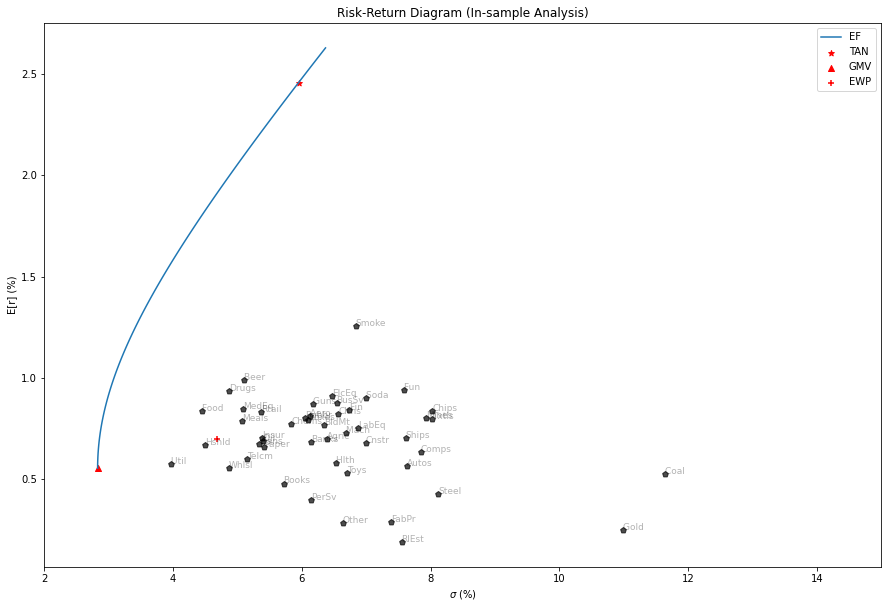

In [ ]:
#Sigma v Mean 
plot_evaluation_results_in_sample(industry_assets)

### Deliverable 2 b)

The β vs. E[r] diagram. This diagram includes the same set of portfolios (the 48 industry
portfolios treated as risky assets, MKT, EWP, TAN, and GMV) and a straight line that
represents the relationship between β and E[r] implied by CAPM (also known as the security
market line)

In [ ]:
def plot_evaluation_results_in_sample_beta (data_train, industry_portfolio, df):

    ###########
    # A Summary function
    #
    # Input: The portfolios are all obtrained from "data_train"; 
    #        Their performances are all evaluated on "data_train" as well
    # Output: A plot that contrains tangency portfolio, GMV, EF, and equally weighted portfolio
    ###########
    
    # Obtain the tangency, GMV, equally weighted portfolios from the TRAINING data
    mu_train = estimate_mu(data_train)
    V_train = estimate_V(data_train)

    w_t_train = tangency(mu_train , V_train)
    w_g_train = gmv(V_train)
    w_e = ewp(data_train.shape[1])
    
    beta_t = (w_t_train * industry_portfolio['beta']).sum()
    beta_g = (w_g_train * industry_portfolio['beta']).sum()
    beta_e = (w_e * industry_portfolio['beta']).sum()
    
    beta = np.arange(0,1.5,0.01)
    y = df['RF'].mean(axis=0) + beta * df['Mkt-RF'].mean(axis=0)
    

    plt.figure(figsize = (15,15))
    
    #CAPM Line 
    
    plt.plot(beta,y,label='CAPM' )
    
    # tangency portfolio (TAN)
    plt.scatter(beta_t, evaluate_portfolio_performance_on_data (w_t_train, data_train)['Er'], marker='*', color = 'red',label = 'TAN', s=100)
    
    # global minimum variance portfolio (GMV)
    plt.scatter( beta_g, evaluate_portfolio_performance_on_data (w_g_train, data_train)['Er'], marker='^', color = 'red',label = 'GMV', s=100)
    
    # equally weighted portfolio (EWP)
    plt.scatter( beta_e, evaluate_portfolio_performance_on_data (w_e, data_train)['Er'], marker='+', color = 'red',label = 'EWP', s=100)
    

    plt.scatter(1, performance_metrics.loc['MKT', 'Expected Return'], label = 'MKT', s=100)


    sectors = list(industry_portfolio.index)

    for com in sectors:

        mean = industry_portfolio.loc[com,"Mean"]
        beta = industry_portfolio.loc[com,"beta"]

        plt.scatter(beta, mean, marker='p', color = 'black', alpha = 0.7)
        plt.text(beta+.0005, mean+.00005, com, fontsize=9, alpha = 0.3)

    
    plt.legend()
    plt.title('Security Market Line')
    plt.xlabel('$Beta$')
    plt.ylabel('E[r] (%)')

    plt.show()

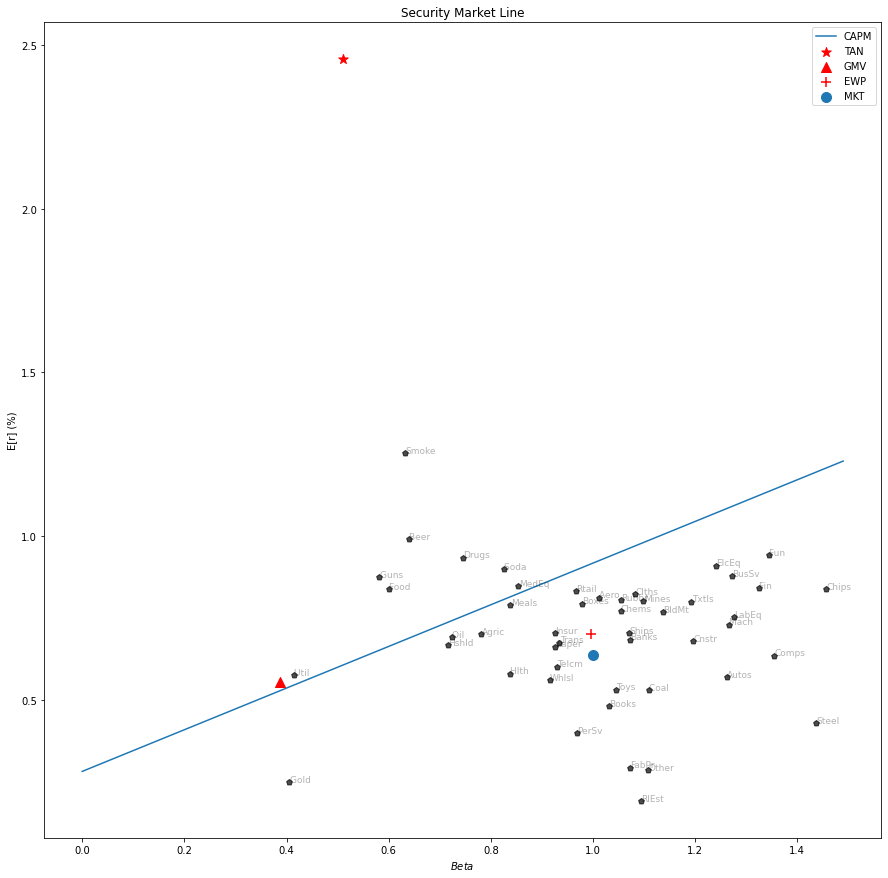

In [ ]:
plot_evaluation_results_in_sample_beta (industry_assets, industry_portfolio, df)

## ROBUST PORTFOLIO CONSTRUCTION AND OUT-OF-SAMPLE ANALYSIS

##### Parameter Estimation

• Estimating Beta. We will use the following shrinkage estimator of beta: βshrink = 0.5β¯ + 0.5β. 

In [ ]:
# Creating the data points for the code testing below
df1 = df.copy()
df1['Month'] = df1['Month'].astype(str)
df1['Year'] = df1['Month'].str[:4].astype(int)

data_train1 = df1.loc[df1['Year'] < 2011].drop(['Month', 'Year'], axis =1)
data_test1 = df1.loc[df1['Year'] >= 2010].drop(['Month', 'Year'], axis =1)

Estimating Expected Return. Since estimating the expected return of an asset is a notoriously
difficult task, we will impose two layers of robustness in the estimation:
- First, we will use the CAPM-based expected return. That is the expected return implied
by CAPM that only depends on the value of beta.

- Second, we will use the robust estimation of beta itself; please see above.
For the easiness of reference, let us call this estimation of return µ(CAPM).

In [ ]:
def beta_shrinkage_est(data):
    
    # This function assumes that the 1st column is the market portfolio
    
    data = data.drop(['RF'], axis = 1)
    sh_constant = 0.5
    
    beta_labels = data.columns
    #print(pd.DataFrame(estimate_V(data)))
    
    #### Calculating the sample betas
    V_beta = pd.DataFrame(estimate_V(data)).iloc[:,0]
    mkt_var = V_beta[0]
    
    betas =  V_beta / mkt_var
    #print('Betas:', betas)
    
    #### calculating the beta grand average
    grand_beta_ave = betas.mean()
    #print('grand_beta_ave:', grand_beta_ave)
    
    # Calculating the beta shrinkage estimator
    
    beta_sh = (sh_constant * betas) + ((1-sh_constant) * grand_beta_ave)
    
    output = {
    'Portfolio': beta_labels,
    'Beta_shrinkage': beta_sh, }
    
    beta_df = pd.DataFrame(output)

    return(beta_df)

In [ ]:
def mu_shrinkage_est(data):
    
    mean_rf = data.loc[:,'RF'].mean()
    mean_mkt_er = data.loc[:, 'Mkt-RF'].mean()
    
    beta_sh = beta_shrinkage_est(data).loc[:, 'Beta_shrinkage']
    
    mu_shrinkage = mean_rf + beta_sh * mean_mkt_er 
      
    return(mu_shrinkage)

- Estimating covariance matrix. 
We will use the following shrinkage estimator of covariance matrix:
Vshrink = 0.3V(CC) + 0.7Vˆ. 

In the expression above, V(CC) is the constant correlation matrix estimated from data, Vˆ is the
sample covariance matrix, and 0.3 is the shrinkage constant that has been determined for you.

Source for correlation matrix: https://gist.github.com/wiso/ce2a9919ded228838703c1c7c7dad13b

In [ ]:
def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation

In [ ]:
def cov_shrinkage_est(data):
    
    # Remove Mkt-RF and RF columns
    data = data.drop(['Mkt-RF', 'RF'], axis = 1)
    
    # Get covariance matrix
    sample_cov = estimate_V(data)
    
    # Get correlation matrix
    sample_corr = correlation_from_covariance(sample_cov)
    
    # Get unique correlations
    n = sample_corr.shape[0]
    corrs = sample_corr[np.triu_indices(n = n, k=1)]
    
    grand_ave_corr = corrs.mean()
    
    # Setting up the VCC
    std = np.sqrt(np.diag(sample_cov))
    std_pdt = np.outer(std, std)
    
    # Testing 
    #s = (48,48)
    #test = np.ones(s)
    
    std_pdt[np.triu_indices(n = n, k=1)] *= grand_ave_corr 
    std_pdt[np.tril_indices(n=n, k=-1)] *= grand_ave_corr
    
    V_cc = std_pdt
    
    # Creating the shrinkage estimator of covariance matrix
    V_shrink = 0.3 * V_cc + 0.7 * sample_cov
        
    V_shrink = pd.DataFrame(V_shrink)
    
    return(V_shrink)

In [ ]:
cov_shrinkage_est(data_test1)

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,51.740554,10.956545,11.849064,10.407174,14.944067,19.383284,27.441208,22.523880,11.397803,17.391749,...,22.718762,19.875254,17.486712,14.243353,13.126172,22.021550,17.697150,29.568450,27.236703,19.040404
1,10.956545,9.344179,6.793429,5.970707,8.757105,9.209747,11.850052,9.067028,6.926363,8.171853,...,10.073590,8.087469,7.500679,7.483144,6.909635,8.574769,8.573283,12.855142,10.549112,8.191489
2,11.849064,6.793429,16.411299,7.762339,11.623072,11.923554,10.298042,7.823767,7.218730,10.092511,...,10.372857,9.924236,7.685283,8.531233,8.140033,8.001642,7.547989,13.207922,9.939036,8.942363
3,10.407174,5.970707,7.762339,9.202336,9.668008,8.534209,8.783212,8.132241,6.025842,6.908523,...,8.105589,8.373501,6.220598,7.117735,6.290541,7.678243,6.898645,11.142347,9.121551,7.928300
4,14.944067,8.757105,11.623072,9.668008,22.736655,13.827841,14.616248,11.599224,9.603625,10.848362,...,13.145991,11.592455,9.319315,10.147656,9.373276,10.760956,9.937333,15.684091,13.198886,11.666644
5,19.383284,9.209747,11.923554,8.534209,13.827841,29.452958,22.572125,15.954426,10.059467,18.677311,...,18.434136,16.137324,14.609684,13.717247,11.980376,16.485884,14.528476,24.403146,20.131947,13.492409
6,27.441208,11.850052,10.298042,8.783212,14.616248,22.572125,53.068955,25.410263,11.890010,24.283836,...,23.553656,21.101090,19.442963,17.294687,17.512066,23.678380,19.597172,33.916085,29.551073,17.960971
7,22.523880,9.067028,7.823767,8.132241,11.599224,15.954426,25.410263,30.081689,10.718697,15.594640,...,18.878777,15.444517,15.585642,14.482917,12.055194,20.438244,16.850477,25.261477,23.500322,16.940830
8,11.397803,6.926363,7.218730,6.025842,9.603625,10.059467,11.890010,10.718697,10.497777,9.494484,...,10.679347,9.213067,8.654513,8.697929,7.106247,10.503891,9.375733,12.852758,12.709831,9.869389
9,17.391749,8.171853,10.092511,6.908523,10.848362,18.677311,24.283836,15.594640,9.494484,29.849956,...,15.329441,15.843653,13.568970,15.445875,13.230528,16.988667,14.991620,24.792697,20.066566,13.547044


Second, with the robust estimation of parameters, we may construct the following robust version
of portfolios:
- TAN-robust: The tangency portfolio using Vshrink and µ_CAPM as problem inputs;
- GMV-robust: The global minimum variance portfolio using Vshrink as the problem input.

In other words, the (only) difference between TAN and TAN-robust is the input parameters (i.e.,
expected return and covariance matrix), and we do not disturb the mathematical optimization problem
itself. A similar thing can be said between GMV and GMV-robust

### Deliverable 3

The out-of-sample σ vs. E[r] diagram. This diagram includes all of the 48 industry portfolios
(treated as risky assets), MKT, and the special portfolios constructed from training data (EWP,
TAN, GMV, TAN-robust, and GMV-robust). All of them are evaluated on the test data. Also,
please include the “true” and “realized” EF curves.

In [ ]:
def plot_evaluation_results_out_sample (data_train, data_test, data_train_full, data_test_full):

    ###########
    # A Summary function
    #
    # Input: The normal portfolios are all obtrained from "data_train"; 
    #        The performances of ALL portfolios are all evaluated on "data_test" ;
    #        The ROBUST portfolios are all obtrained from "data_train_full";
    #        The Market portfolio is obtained from "data_test_full";
    # Output: A plot that contains tangency portfolio, GMV, EF, equally weighted portfolio, TAN-Robust and GMV-Robust
    ###########
    
    
    ############################### "TRUE" EF CURVE ###################################
    
    ####
    # Construct the "True" tangency, GMV, equally weighted portfolios from the testing data...
    # and evaluate them on testing data
    

    mu_test = estimate_mu(data_test)
    V_test = estimate_V(data_test)

    w_t_test = tangency(mu_test , V_test)
    w_g_test = gmv(V_test)
    
  
    ####
    # The "True" EF is based on portfolios both constructed and evaluated on the TESTING data
    figure(figsize=(10, 6), dpi=80)
    sigma_true_range, Er_true_range = get_EF_on_data (w_t_test, w_g_test, data_test)
    plt.plot(sigma_true_range, Er_true_range, label = 'True EF')
    #
    ####
    
    ############################### SPECIAL PORTFOLIOS FROM TRAINING DATA ###################################
    
    ####
    # Obtain the special portfolios constructed from the training data
    mu_train = estimate_mu(data_train)
    V_train = estimate_V(data_train)

    w_t_train = tangency(mu_train , V_train)
    w_g_train = gmv(V_train)
    
    w_e = ewp(data_train.shape[1]) # NB: the EWP portfolio is actually independent of the historical return
    
    # Obtain the special ROBUST portfolios constructed from the training data
    mu_train_robust = mu_shrinkage_est(data_train_full)[1:] # Exclude the 1st row which is the market returns
    V_train_robust = cov_shrinkage_est(data_train_full)

    w_Rt_train = tangency(mu_train_robust , V_train_robust)
    w_Rg_train = gmv(V_train_robust)
    
   
    #
    ####
    
    
    ################################ PLOT SPECIAL PORTFOLIOS ON TEST DATA ###################################
    
    # Plot the Tangency portfolio (TAN)
    plt.scatter( evaluate_portfolio_performance_on_data (w_t_train, data_test)['sigma'], 
                evaluate_portfolio_performance_on_data (w_t_train, data_test)['Er'], marker='*', color = 'red',label = 'TAN')
    
    # Plot the Global minimum variance portfolio (GMV)
    plt.scatter( evaluate_portfolio_performance_on_data (w_g_train, data_test)['sigma'], 
                evaluate_portfolio_performance_on_data (w_g_train, data_test)['Er'], marker='^', color = 'red',label = 'GMV')
    
    # Plot the Equally weighted portfolio (EWP)
    plt.scatter( evaluate_portfolio_performance_on_data (w_e, data_test)['sigma'], 
                evaluate_portfolio_performance_on_data (w_e, data_test)['Er'], marker='+', color = 'red',label = 'EWP')
    
     # Plot the Tangency portfolio (TAN)
    plt.scatter( evaluate_portfolio_performance_on_data (w_Rt_train, data_test)['sigma'], 
                evaluate_portfolio_performance_on_data (w_Rt_train, data_test)['Er'], marker='*', color = 'gold',label = 'TAN-ROBUST')
    
    # Plot the Global minimum variance portfolio (GMV)
    plt.scatter( evaluate_portfolio_performance_on_data (w_Rg_train, data_test)['sigma'], 
                evaluate_portfolio_performance_on_data (w_Rg_train, data_test)['Er'], marker='^', color = 'gold',label = 'GMV-ROBUST')
    
    
    # Market portfolio (MKT)
    mkt_sigma = data_test_full.loc[:, 'Mkt-RF'].std()
    mkt_er = data_test_full.loc[:, 'Mkt-RF'].mean()
    
    plt.scatter(mkt_sigma, mkt_er,marker = '>', color = 'red',label = 'MKT')
    
    # individual assets, assuming input is a square covariance matrix
    dimension = np.shape(V_test)[0]

    for i in range(0,dimension):
        name = data_test.columns[i]
        plt.scatter(np.sqrt(V_test[i,i]), mu_test[i], marker='p', color = 'black', alpha = 0.6)
        plt.text(np.sqrt(V_test[i,i])+.0005, mu_test[i]+.00005, name, fontsize=9, alpha = 0.2)
    
    #
    ####
    
    ############################### 'REALISED' EF CURVE ####################################
    
    ####
    # The "Realized" EF is based on portfolios constructed from TRAINING data but evaluated on TESTING data
    sigma_realized_range, Er_realized_range = get_EF_on_data (w_t_train, w_g_train, data_test)
    plt.plot(sigma_realized_range, Er_realized_range, '--', label = 'Realized EF')
    #
    ####

    plt.legend()
    plt.title('Risk-Return Diagram (Out-of-sample Analysis)')
    plt.xlabel('$\sigma$ (%)')
    plt.ylabel('E[r] (%)')
    
    plt.show()
    
    ###### PRINT ADDITIONAL INFORMATION
    print('******')
    print('The tangency portfolio constructed from the testing data is: ', np.round(w_t_test,3))
    print('The global minimum variance portfolio constructed from the testing data  is: ', np.round(w_g_test,3))
    print('******') 
    print('The tangency portfolio constructed from the training data is: ', np.round(w_t_train,3))
    print('The global minimum variance portfolio constructed from the training data  is: ', np.round(w_g_train,3))
    print('******')
    print('The ROBUST tangency portfolio constructed from the training data is: ', np.round(w_Rt_train,3))
    print('The ROBUST global minimum variance portfolio constructed from the training data  is: ', np.round(w_Rg_train,3))
    print('******')

In [ ]:
## Splitting datasets
df1 = df.copy()
df1['Month'] = df1['Month'].astype(str)
df1['Year'] = df1['Month'].str[:4].astype(int)

data_train = df1.loc[df1['Year'] < 2011].drop(['Month', 'Year', 'Mkt-RF', 'RF'], axis =1)
data_test = df1.loc[df1['Year'] >= 2011].drop(['Month', 'Year', 'Mkt-RF', 'RF'], axis =1)

data_train_full = df1.loc[df1['Year'] < 2011].drop(['Month', 'Year'], axis =1)
data_test_full = df1.loc[df1['Year'] >= 2011].drop(['Month', 'Year'], axis =1)

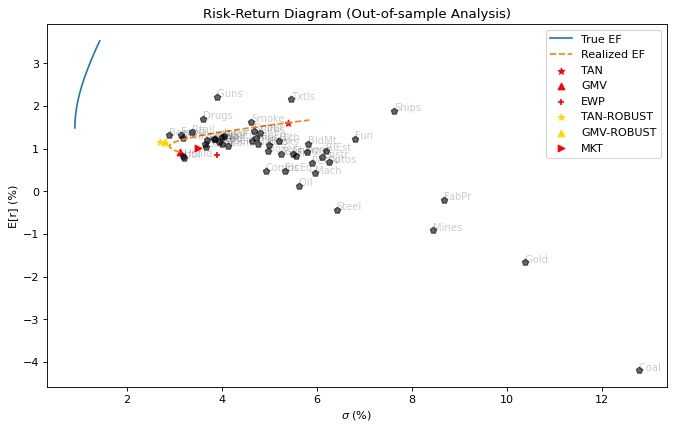

******
The tangency portfolio constructed from the testing data is:  [ 0.173  0.769 -0.844  0.212  0.183 -0.163 -0.221 -0.035 -0.298  0.059
  0.048 -0.468 -0.067 -0.193  0.632  0.399 -0.196 -0.354 -0.68  -0.122
  1.389 -0.526 -0.014 -0.639 -0.431  0.893  0.067 -0.008  0.099  0.096
 -0.036  0.528 -0.066  0.495 -0.755  0.71   0.554 -0.373 -0.67   0.198
  0.694  0.426  0.164  1.33  -1.35   0.095 -0.673 -0.031]
The global minimum variance portfolio constructed from the testing data  is:  [ 0.107  0.214 -0.329  0.362  0.122 -0.272 -0.089 -0.054 -0.015  0.09
  0.086 -0.281 -0.341 -0.122 -0.056  0.133 -0.237 -0.2   -0.336 -0.011
  0.581 -0.264 -0.067 -0.241 -0.273  0.432  0.113  0.086  0.07  -0.026
  0.127  0.228 -0.014  0.382 -0.339 -0.07   0.567  0.131 -0.322 -0.028
  0.874  0.252  0.078  0.501 -0.34   0.059 -0.28   0.015]
******
The tangency portfolio constructed from the training data is:  [-0.183  0.148  0.136  0.047  0.364 -0.401  0.431 -0.233 -0.122  0.02
 -0.025  0.608  0.285 -0.201  

In [ ]:
plot_evaluation_results_out_sample(data_train, data_test, data_train_full, data_test_full)

### Deliverable 4

Compare the out-of-sample performances of MKT, EWP, TAN, TAN-robust, GMV, and GMVrobust using the definitions and methods introduced above. Report your results in a 3 by 6
table. (Recall that we have 3 performance metrics and 6 portfolios to compare.)


In [ ]:
# Construct the TAN and GMV

# Training on the dataset only with 48 assets
mu_train = estimate_mu(data_train)
V_train = estimate_V(data_train)

w_t_train = tangency(mu_train , V_train)
w_g_train = gmv(V_train)

# Construct the TAN-robust and the GMV-robust

mu_train_robust = mu_shrinkage_est(data_train_full)[1:] # Exclude the 1st row which is the market returns
V_train_robust = cov_shrinkage_est(data_train_full)

w_Rt_train = tangency(mu_train_robust , V_train_robust)
w_Rg_train = gmv(V_train_robust)

# Construct EWP
w_e_train = ewp(data_train.shape[1])

outcomes = [w_t_train, w_g_train, w_e_train, w_Rt_train, w_Rg_train]
labels = ['MKT', 'TAN', 'GMV', 'EWP', 'TAN-ROBUST', 'GMW-ROBUST' ]

# Using the test data to derive market sigma and ER
mkt_sigma = data_test_full.loc[:, 'Mkt-RF'].std()
mkt_er = data_test_full.loc[:, 'Mkt-RF'].mean()
mkt_sharpe = mkt_er/mkt_sigma

sigma_list = [mkt_sigma]
er_list = [mkt_er]
sharpe_list = [mkt_sharpe]

# Evaluated on the test data
for i in range(len(outcomes)):
    
    w = outcomes[i]
    label = labels[i]
    
    sigma = evaluate_portfolio_performance_on_data (w, data_test) ['sigma']
    er = evaluate_portfolio_performance_on_data (w, data_test) ['Er']
    sharpe = er/sigma
    
    sigma_list.append(sigma)
    er_list.append(er)
    sharpe_list.append(sharpe)

### Creating the 3 in-sample performance metrics
  
output = {
    'Portfolio': labels,
    'Excess Returns': er_list,
    'Standard Deviation': sigma_list,
    'Sharpe Ratio': sharpe_list,      
}

metrics = pd.DataFrame(output)

print("Out-of-Sample Performances")
metrics

Out-of-Sample Performances


,Portfolio,Excess Returns,Standard Deviation,Sharpe Ratio
0,MKT,1.010833,3.502378,0.288613
1,TAN,1.606994,5.395611,0.297834
2,GMV,0.917728,3.111275,0.294968
3,EWP,0.845597,3.891562,0.217290
4,TAN-ROBUST,1.159521,2.702104,0.429118
5,GMW-ROBUST,1.156145,2.798023,0.413201


In [ ]:
# Construct the TAN and GMV

# Training on the dataset only with 48 assets
mu_train = estimate_mu(data_train)
V_train = estimate_V(data_train)

w_t_train = tangency(mu_train , V_train)
w_g_train = gmv(V_train)

# Construct the TAN-robust and the GMV-robust

mu_train_robust = mu_shrinkage_est(data_train_full)[1:] # Exclude the 1st row which is the market returns
V_train_robust = cov_shrinkage_est(data_train_full)

w_Rt_train = tangency(mu_train_robust , V_train_robust)
w_Rg_train = gmv(V_train_robust)

# Construct EWP
w_e_train = ewp(data_train.shape[1])

outcomes = [w_t_train, w_g_train, w_e_train, w_Rt_train, w_Rg_train]
labels = ['MKT', 'TAN', 'GMV', 'EWP', 'TAN-ROBUST', 'GMW-ROBUST' ]

# Using the train data to derive market sigma and ER
mkt_sigma = data_train_full.loc[:, 'Mkt-RF'].std()
mkt_er = data_train_full.loc[:, 'Mkt-RF'].mean()
mkt_sharpe = mkt_er/mkt_sigma

sigma_list = [mkt_sigma]
er_list = [mkt_er]
sharpe_list = [mkt_sharpe]

# Evaluated on the TRAINING data
for i in range(len(outcomes)):
    
    w = outcomes[i]
    label = labels[i]
    
    sigma = evaluate_portfolio_performance_on_data (w, data_train) ['sigma']
    er = evaluate_portfolio_performance_on_data (w, data_train) ['Er']
    sharpe = er/sigma
    
    sigma_list.append(sigma)
    er_list.append(er)
    sharpe_list.append(sharpe)

### Creating the 3 in-sample performance metrics
  
output = {
    'Portfolio': labels,
    'Excess Returns': er_list,
    'Standard Deviation': sigma_list,
    'Sharpe Ratio': sharpe_list,      
}

metrics = pd.DataFrame(output)

print("In-Sample Performances")
metrics

In-Sample Performances


,Portfolio,Excess Returns,Standard Deviation,Sharpe Ratio
0,MKT,0.561467,4.657505,0.120551
1,TAN,2.865147,7.199043,0.397990
2,GMV,0.441403,2.825654,0.156213
3,EWP,0.670738,4.832560,0.138796
4,TAN-ROBUST,0.528530,3.124750,0.169143
5,GMW-ROBUST,0.498571,2.995889,0.166418
